In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, plot_confusion_matrix
import numpy as np

In [13]:
# Import Data
df = pd.read_sas('../Data/nsch_2020_topical_SAS/nsch_2020_topical.sas7bdat')

In [14]:
# Checking for NaN values
df.isna().sum()

FIPSST       0
STRATUM      0
HHID         0
FORMTYPE     0
TOTKIDS_R    0
            ..
FPL_I3       0
FPL_I4       0
FPL_I5       0
FPL_I6       0
FWC          0
Length: 443, dtype: int64

In [15]:
# There are only a 188 NANs in the target, I will opt to drop them
df.dropna(subset=['K2Q31A'], inplace=True)

In [16]:
# For the rest of the columns, I will fill in a value that CATBOOST will easily be able to identify as a NAN
df.fillna(-999, inplace=True)

In [17]:
# Target: Diagnosed ADHD
y = df['K2Q31A']

# Dropping ANYTHING related to ADHD and treatment
X = df.drop(columns=['K2Q31A', 'ADDTREAT', 'K2Q31B', 'K2Q31C', 'K2Q31D', 'K4Q23', 'SC_K2Q12', 'SC_K2Q10', 'SC_K2Q11'])

In [18]:
# Get the indices of object columns
categorical_features_indices = np.where(df.dtypes != float)[0]

In [19]:
# TTS
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

In [20]:
# Setting up the model
model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)

In [21]:
# Fit the model on the data.
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    # Plot the learning of the model
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
# Cross Validate
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X, list(y), cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
# print the best validation accuracy score
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.94±0.00 on step 945


In [24]:
# Printing the ean accuracy score
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.9394679685369484


/Users/matthewturner/opt/anaconda3/envs/Capstone/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


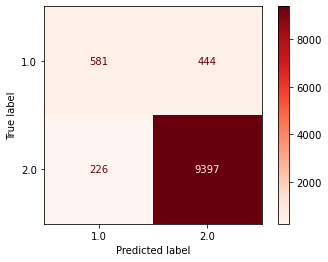

In [25]:
# Plot confusion Matrix for test set.
plot_confusion_matrix(model, X_validation, y_validation, cmap='Reds')

In [26]:
accuracy_score(y_validation, model.predict(X_validation))

0.9370773854244928

In [27]:
precision_score(y_validation, model.predict(X_validation))

0.7199504337050805

In [28]:
recall_score(y_validation, model.predict(X_validation))

0.5668292682926829

In [29]:
f1_score(y_validation, model.predict(X_validation))

0.6342794759825328

In [30]:
roc_auc_score(y_validation, model.predict(X_validation))

0.7716719343645687

# Top 10 Features

In [31]:
importance = model.get_feature_importance(prettified=True)
importance

,Feature Id,Importances
0,SC_CSHCN,5.720871
1,FORMTYPE,4.964272
2,MENBEVCOV,3.515523
3,TELLSTORY,3.437380
4,MEMORYCOND,3.314904
...,...,...
429,CURRINS,0.000000
430,INSGAP,0.000000
431,BIRTHWT,0.000000
432,A1_GRADE_IF,0.000000


- **SC_CSHCN** = Special Health Care Needs Status of Selected Child
<br>

- **FORMTYPE** = Administrative variable, and index column
<br>

- **MENBEVCOV** - Health Insurance -Thinking specifically about this child's mental or behavioral health needs, how often does this child's health insurance offer benefits or cover services that meet these needs?
1 = Always
2 = Usually
3 = Sometimes
4 = Never
5 = This child does not use mental or behavioral health services
<br>

- **TELLSTORY** - Is this child able to do the following:
Tell a story with a beginning, middle, and end?
<br>

- **MEMORYCOND** - Does this child have serious difficulty concentrating, remembering, or making decisions because of a physical, mental, or emotional condition
<br>

- **K2Q34A** = Has a doctor, other health care provider, or educator EVER told you that this child
has Behavioral or Conduct Problems?
<br>

- **SC_SEX** = Sex of child in question
<br>

- **SESPLANYR** is a Subquestion of
    - K6Q15: Has this child EVER had a special education or early intervention plan?"
        - 'SESPLANYR' : "How old was the child at the time of the FIRST plan?"
<br>

- **TOTCSHCN** = Count of Children with Special Health Care Needs in Household
<br>

- **K7Q84_R** = How often does this child work to finish tasks they start?
1 = Always
2 = Usually
3 = Sometimes
4 = Never
<br>

## Analysis
Looking at these and applying domain knowledge, I think most of this makes sense.
- **MEMORYCOND, TELLSTORY, K2Q34A (Conduct Problems), and K7Q84_R (Unfinished tasks)** are all symptoms of ADHD
- **SC_SEX** makes sense because [boys are more likely to be diagnosed with ADHD than girls (12.9% compared to 5.6%)](https://pubmed.ncbi.nlm.nih.gov/29363986/)
- **FORMTYPE** actually has to do with the age group. Households received one of the three age-specific topical questionnaires based on the age of the sampled child:
    • NSCH-T1 (or T1) for children aged 0-5 years,
    • NSCH-T2 (or T2) for children aged 6-11 years, or
    • NSCH-T3 (or T3) for children aged 12-17 years.
- **MENBEVCOV, SESPLANYR** should probably be looked into more. I could see multiple reasons the model feels this is important.
- **TOTCSHCN** Should be dropped, this is most likly giving away the answer, I don't think ADHD has any correlation with the amount of kids in a household that have special health care needs


There are some other features that I'm surprised aren't in the top 10. Like if the child is diagnosed with depression, or an anxiety disorder.


In [42]:
# Checking Importance of "Diagnosed with Depression" column
importance[importance['Feature Id'] == 'K2Q32A']

,Feature Id,Importances
139,K2Q32A,0.146227
